# Analyse des décès covid par statut vaccinal 


## Résumé

Cette feuille de calcul [Jupyter](https://jupyter.org/) analyse les données de décès de la DREES, par statut vaccinal et par âge, et tente d'évaluer les décès évités par la vaccination, et ceux qui auraient pu l'être avec une couverture vaccinale complète.


## Données

Les données proviennent du site de la DREES. Elle comportent les décès depuis juin 2021, par statut vaccinal, dat et tranche d'âge

https://data.drees.solidarites-sante.gouv.fr/explore/dataset/covid-19-resultats-par-age-issus-des-appariements-entre-si-vic-si-dep-et-vac-si/information/

## Méthodologie 

Pour chaque tranche d'âge, chaque statut vaccinal et chaque date, la DREES fournit les effectifs du groupe correspondant (age et statut vaccinal), à date. Ceci permet de calculer une mortalité journalière pour chaque sous groupe.

Il est alors possible de simuler des scénarios de couverture vaccinale (0% et 100%) appliquant la mortalité d'un sous groupe à l'autre, pour une même tranche d'âge.

## Limitations

Ces calculs reposent sur l'hypothèse que la différence de mortalité des groupes vaccinés et non-vaccinés dépend essentiellement de leur statut vaccinal. Le facteur de confusion "âge" est pris en compte par la strafification par âge déjà appliquée par la DREES. 

D'autres facteurs de confusion peuvent néamoins subsister:

* **Comorbidités** : Chez les plus jeunes surtout (0-19 ans), les individus présentant des comorbidités ont été vaccinés en priorité. L'ignorance de cette corrélation tend à sous estimer l'impact positif de la vaccination.

* **Classes sociales** : Les classes populaires sont à la fois moins plus vulnérables et moins vaccinées que le reste de la population. [1](https://www.cdc.gov/mmwr/volumes/70/wr/mm7022e1.htm) [2](https://www.huffingtonpost.fr/entry/vaccination-la-richesse-ou-les-diplomes-insuffisants-pour-expliquer-le-choix-de-ceux-qui-decident-de-ne-pas-le-faire_fr_61166e34e4b07c1403142492). L'ignorance de cette corrélation tend à surestimer l'impact positif de la vaccination.

* **Transmission** : Cette étude ne considère pas l'effet de la vaccination sur la transmission ([évalué à 40% environ](https://www.france24.com/en/live-news/20211124-vaccines-reduce-covid-transmission-by-40-who)). L'ignorance de cet tend à sous estimer l'impact positif de la vaccination.

# Code 

Le code est disponible sur Github :
https://github.com/raphaeljolivet/drees-deces


# Auteur

Raphaël Jolivet : https://mamot.fr/@RaphJ


# Licence

Cette feuille de calcul est distribuée sous [licence CC-By](https://creativecommons.org/licenses/by/4.0/)



# Initialisation

In [2]:
# Import de librairies
import pandas as pd
import matplotlib.pyplot as plt

# Taille par défaut des graphes
plt.rc('figure', figsize=(10,7))

# Chargement des données

In [3]:
data = pd.read_csv("drees-covid-age.csv", sep=";", parse_dates=["date"]).fillna(0)
data

,date,vac_statut,age,nb_PCR,nb_PCR_sympt,nb_PCR+_sympt,nb_PCR+,HC,HC_PCR+,SC,SC_PCR+,DC,DC_PCR+,effectif
0,2021-05-31,Primo dose efficace,"[0,19]",541.14,49.02,2.04,8.38,0.17,0.00,0.00,0.00,0.00,0.00,54186
1,2021-05-31,Complet de moins de 3 mois - sans rappel,"[0,19]",254.92,22.68,7.18,21.56,0.13,0.00,0.00,0.00,0.00,0.00,16776
2,2021-05-31,Complet entre 3 mois et 6 mois - sans rappel,"[0,19]",6.60,1.24,0.10,0.80,0.00,0.00,0.00,0.00,0.00,0.00,464
3,2021-05-31,Non-vaccinés,"[20,39]",54727.91,7383.31,1539.77,3317.99,49.74,38.50,7.61,6.00,0.00,0.00,12135472
4,2021-05-31,Primo dose efficace,"[20,39]",6660.51,646.63,33.70,92.78,0.11,0.00,0.13,0.00,0.00,0.00,1214317
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7411,2021-12-05,Complet de moins de 3 mois - avec rappel,"[40,59]",20.76,0.11,0.00,0.05,0.00,0.00,0.00,0.00,0.00,0.00,13005
7412,2021-12-05,Complet de moins de 3 mois - sans rappel,"[60,79]",493.31,34.97,2.17,18.96,6.21,5.01,6.24,3.59,0.00,0.00,616999
7413,2021-12-05,Non-vaccinés,[80;+],684.52,96.74,28.66,80.67,58.68,35.08,4.75,4.75,29.84,21.34,240617
7414,2021-12-05,Primo dose récente,[80;+],27.84,3.74,0.00,1.11,0.00,0.00,0.00,0.00,0.00,0.00,9302


# Pivot par statut vaccinal et aggrégation 

On pivote les données pour avoir une colonne par statut vaccinal.
Les statuts vaccinaux sont ensuite groupés :
* Les 6 sous groupes "complet" => "vax"
* Les non vaccinés et vaccinés une dose seulement => "non vax"

In [4]:
# Pivot par statut vaccinal, pour les décès et les effectifs
dc = data.pivot(index=["age", 'date'], columns='vac_statut', values="DC").fillna(0)
eff = data.pivot(index=["age", 'date'], columns='vac_statut', values="effectif").fillna(0)

In [5]:
def vax_nvax(df) :
    """Aggrège les vax et non-vax"""

    # Liste des 6 colonnes Complet ...
    cols_complet = [col for col in df.columns if 'Complet' in col]

    # On crée une colonne "Complet" somme des 6 autres
    df["vax"] = sum(df[col] for col in cols_complet)
    
    # Les primo dose sont classés dans les non vaccinés
    df["non_vax"] = df["Non-vaccinés"] + df["Primo dose efficace"] + df["Primo dose récente"]
    
    return df[["non_vax", "vax"]]

In [6]:
dc = vax_nvax(dc)

In [7]:
eff = vax_nvax(eff)

# Ratios  & scénarios

On aggrège les tableaux de décès et d'effectifs et on calcule les ratios :
 * **ratio_vax** = dc_vax / effectif_vax
 * **ratio_non_vax** = dc_non_vax / effectif_non_vax
 * **dc_vax_1m** = ratio_vax * 1000000
 * **dc_non_vax_1m** = ratio_non_vax * 1000000
 * **dc_0** (hypothèse 0% vax) = dc_non_vax + ratio_non_vax * effectif_vax
 * **dc_100** (hypothèse 100% vax) = dc_vax + ratio_vax * effectif_non_vax
 * **dc_evites** = dc_0 - (dc_vax + dc_non_vax)
 * **dc_evitables** = (dc_vax + dc_non_vax) - dc_100

In [8]:
# Aggregate two dataframes
dc["eff_vax"] = eff["vax"]
dc["eff_non_vax"] = eff["non_vax"]

In [9]:
# Ratio DC / effectif for each group
dc["ratio_vax"] = dc["vax"] / eff["vax"]
dc["ratio_non_vax"] = dc["non_vax"] / eff["non_vax"]

# DC for 1 million of each group
dc["dc_vax_1m"] = dc["ratio_vax"] * 1000000
dc["dc_non_vax_1m"] = dc["ratio_non_vax"] * 1000000

# If noone was vaccinated : 
# assume same death rate of vaccinated group
dc["dc_0"] = dc["non_vax"]  + dc["ratio_non_vax"] * eff["vax"]

# If everyone was vaccinated
# assume same death rate for unvaccinated group
dc["dc_100"] = dc["vax"] + dc["ratio_vax"] * eff["non_vax"]

In [10]:
# Sum dataframe
somme = dc.groupby(level=0).sum()
somme = somme[["non_vax", "vax", "dc_0", "dc_100", "dc_vax_1m", "dc_non_vax_1m"]]
somme["dc_all"] = (somme.vax+somme.non_vax)
somme["saved"] = somme.dc_0 - somme.dc_all
somme["to_save"] = somme.dc_all - somme.dc_100
somme = somme.astype(int)

# Graphes

## Décès par tranche d'âge et statut vaccinal

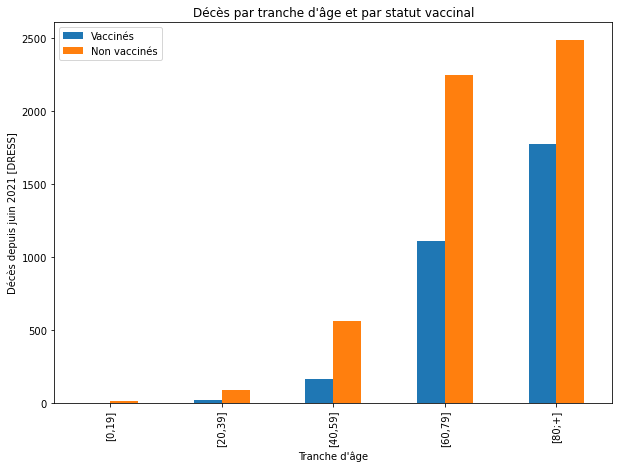

In [11]:
somme[["vax", "non_vax"]].plot.bar(
    title="Décès par tranche d'âge et par statut vaccinal",
    ylabel="Décès depuis juin 2021 [DRESS]",
    xlabel="Tranche d'âge")
plt.legend(["Vaccinés", "Non vaccinés"])

## Décès par tranche d'âge et statut vaccinal, normés pour 1 million d'individus

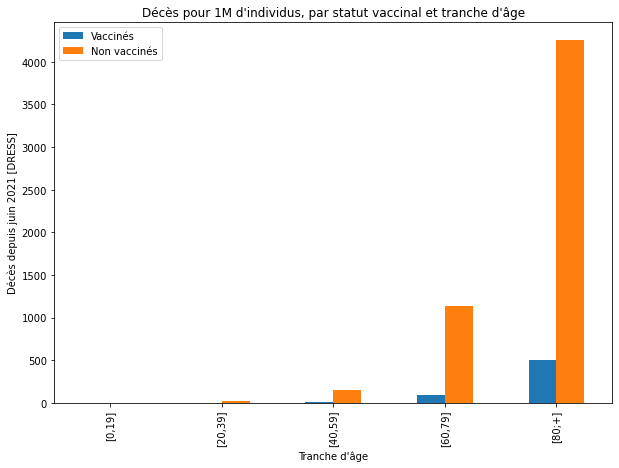

In [12]:
somme[["dc_vax_1m", "dc_non_vax_1m"]].plot.bar(
    title="Décès pour 1M d'individus, par statut vaccinal et tranche d'âge",
    ylabel="Décès depuis juin 2021 [DRESS]",
    xlabel="Tranche d'âge")
plt.legend(["Vaccinés", "Non vaccinés"])

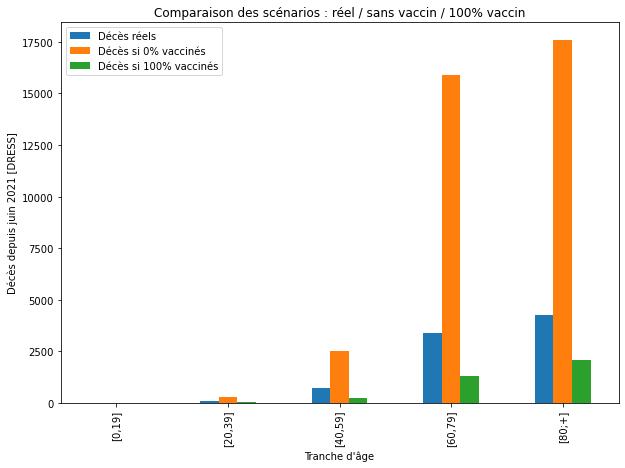

In [13]:
somme[["dc_all", "dc_0", "dc_100"]].plot.bar(
    title="Comparaison des scénarios : réel / sans vaccin / 100% vaccin",
    ylabel="Décès depuis juin 2021 [DRESS]",
    xlabel="Tranche d'âge")
plt.legend(["Décès réels", "Décès si 0% vaccinés", "Décès si 100% vaccinés"])

# Tableau récapitulatif

In [14]:
summary = somme.append(somme.sum().rename('Total'))
summary[["non_vax", "vax", "dc_0", "dc_100", "saved", "to_save"]].rename(columns={
    "non_vax" : "décès non-vax", 
    "vax" : "décès vax",
    "dc_0" : "décès si 0% vacciné", 
    "dc_100" : "décès si 100% vaccinés",
    "saved" : "décès évités", 
    "to_save" : "décès évitables", 
})

vac_statut,décès non-vax,décès vax,décès si 0% vacciné,décès si 100% vaccinés,décès évités,décès évitables
age,,,,,,
"[0,19]",11,2,13,10,0,2
"[20,39]",85,22,277,32,169,75
"[40,59]",563,163,2524,239,1797,487
"[60,79]",2249,1112,15881,1300,12520,2061
[80;+],2483,1774,17574,2057,13316,2199
Total,5391,3073,36269,3638,27802,4824
